# Camera Pose Estimation

In [1]:
import cv2  # pip install opencv-contrib-python
import numpy as np
import imageio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from tqdm import tqdm
from copy import deepcopy
from IPython.display import Image

### 1. ArUco Marker

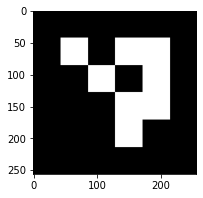

True

In [2]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
aruco = cv2.aruco.drawMarker(aruco_dict, 0, 256)
plt.figure(figsize=(3,3)); plt.imshow(aruco, cmap="gray"); plt.show()
cv2.imwrite("src/aruco.png", aruco)

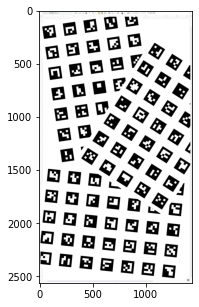

In [3]:
plt.figure(figsize=(5,5)); 
plt.imshow(cv2.imread('src/manyaruco.png')[...,::-1])
plt.show()

### 2. Video

In [4]:
vid = np.array(imageio.mimread("src/aruco.mp4", memtest=False))
print(vid.shape)

(364, 1080, 1920, 3)


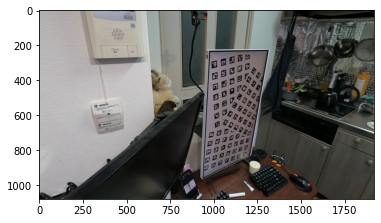

In [5]:
plt.imshow(vid[0]); plt.show()

### 3. Load camera params

In [6]:
marker_length = 0.0273 # [m] ### caution！
mtx = np.load("camera/mtx.npy")
dist = np.load("camera/dist.npy")
print(mtx); print(dist)

[[1.00631525e+03 0.00000000e+00 9.56573461e+02]
 [0.00000000e+00 1.00416463e+03 5.50061327e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.02529833 -0.02409825  0.00238566 -0.00035251 -0.02531333]]


### 4. Detect

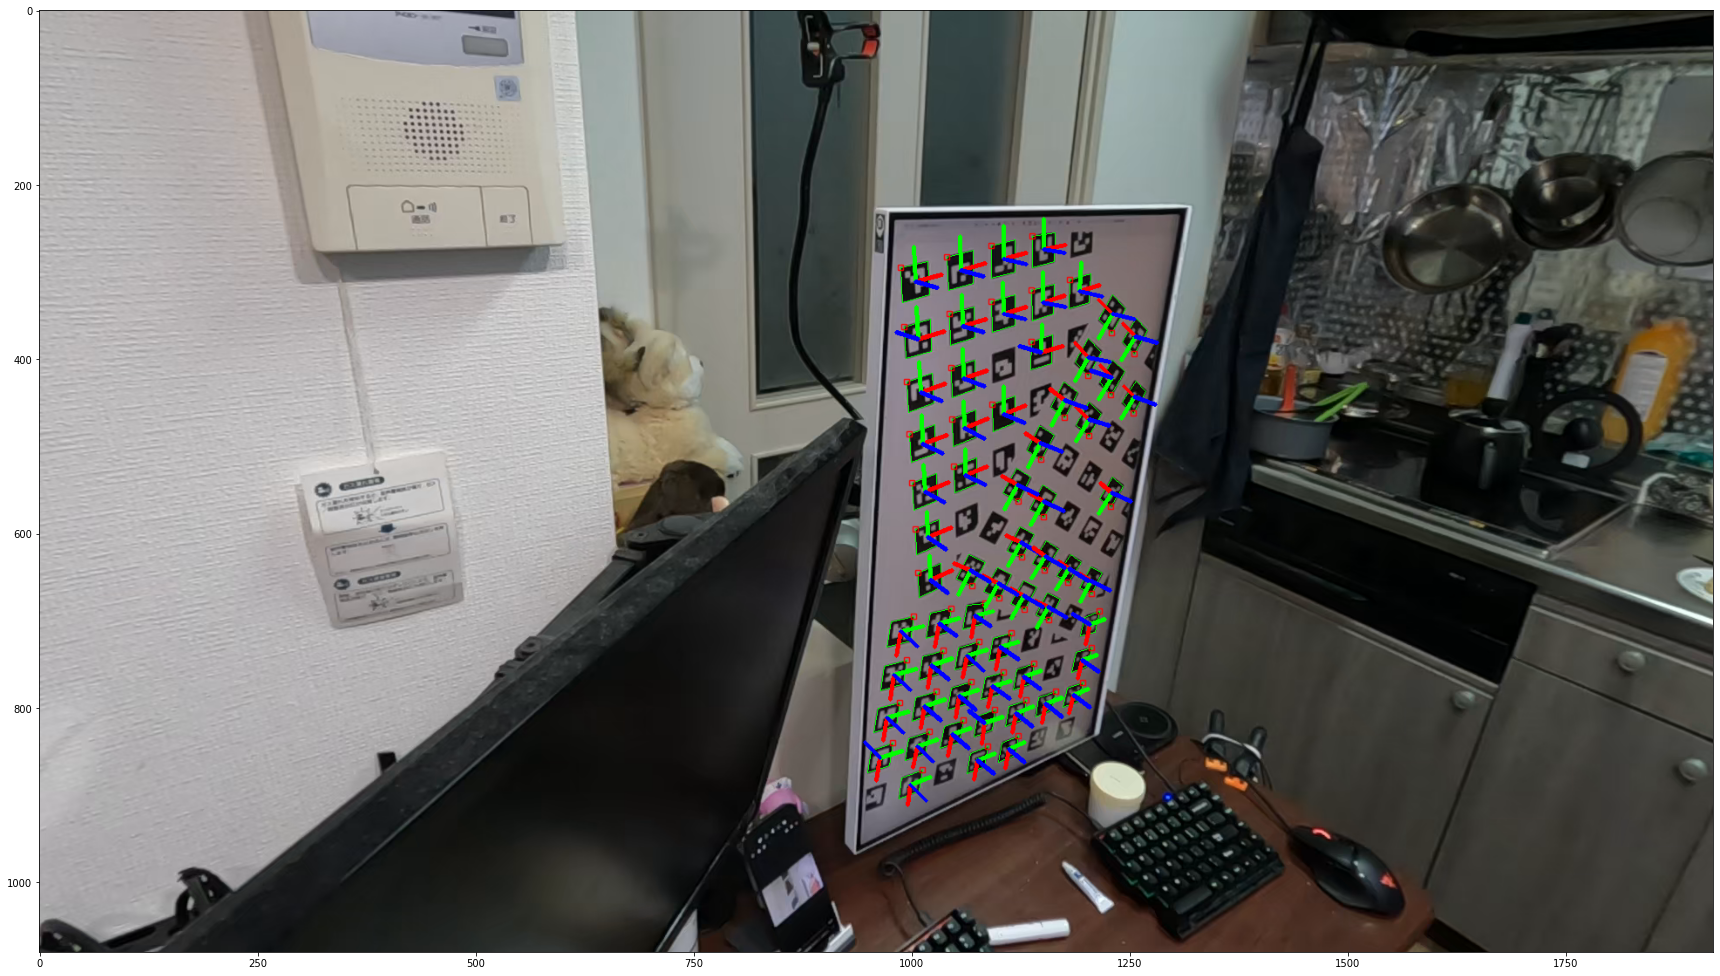

In [7]:
for i, frame in enumerate(vid):
    frame = deepcopy(frame[...,::-1])  # BGR2RGB

    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict)
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, mtx, dist)

    if not len(rvecs) == 0:
        frame = cv2.aruco.drawDetectedMarkers(frame, corners)
        for rvec, tvec in zip(rvecs, tvecs):
            frame = cv2.drawFrameAxes(frame, mtx, dist, rvec, tvec, marker_length)

        plt.figure(figsize=(30,30)); plt.imshow(frame[...,::-1]); plt.show()
        break

### 5. Get Camera Pose Trajectory

In [8]:
rvec_hist = []
tvec_hist = []
skip = 25

for frame in vid[::skip]:
    frame = deepcopy(frame[...,::-1])
    corners, ids, _ = cv2.aruco.detectMarkers(frame, aruco_dict)    
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, mtx, dist)
    idx = np.where(ids.squeeze()==0)

    if len(rvecs) == 0 or len(idx[0]) == 0:
        continue

    rvec_hist.append(rvecs[idx])
    tvec_hist.append(tvecs[idx])

In [9]:
def plot_all_frames(rvecs, tvecs, elev=90, azim=270):
    frames = []

    for t, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        R = cv2.Rodrigues(rvec)[0]
        T = tvec[0].T
        xyz = np.dot(R.T, - T).squeeze()
        rpy = np.deg2rad(cv2.RQDecomp3x3(R.T)[0])  # (not used)

        fig = plt.figure(figsize=(4,3))
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlim(-2, 2); ax.set_ylim(-2, 2); ax.set_zlim(-2, 2)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

        dx = np.dot(R.T, np.array([1,0,0]))
        dy = np.dot(R.T, np.array([0,1,0]))
        dz = np.dot(R.T, np.array([0,0,1]))

        # draw marker
        ax.scatter(0, 0, 0, color="k")
        ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
        ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
        ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")
        ax.plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], [0,0,0,0,0], color="k", linestyle=":")

        # draw camera
        colors = ['k', 'k', 'k'] if t < 5 else ['r', 'g', 'b']
        ax.quiver(*xyz, *dx, length=0.5, color=colors[0])
        ax.quiver(*xyz, *dy, length=0.5, color=colors[1])
        ax.quiver(*xyz, *dz, length=0.5, color=colors[2])

        # save for animation
        fig.canvas.draw()
        frames.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()

    return frames

In [10]:
frames = plot_all_frames(rvec_hist, tvec_hist, elev=105, azim=270)
imageio.mimwrite("src/sample1.gif", frames); Image(url='src/sample1.gif')

In [11]:
frames = plot_all_frames(rvec_hist, tvec_hist, elev=165, azim=270)
imageio.mimwrite("src/sample2.gif", frames); Image(url='src/sample2.gif')